In [1]:
import pandas as pd
import numpy as np
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import datetime as dt
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# assign dataset names
list_of_names = ['01.geo','02.customers','03.sellers','04.order_status','05.order_items',
                '06.order_payments','07.product_reviews','08.products']

# create empty list
df = []
  
# append datasets into the list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv (list_of_names [i] + ".csv", encoding="ISO-8859-1",delimiter = ";")
    df.append(temp_df)

In [3]:
geo =df[0] #geo
customers =df[1] #customers
sellers =df[2]  #sellers
order_status =df[3]  #order status
order_items =df[4]  #order items
order_payments =df[5]  #order payments
order_reviews =df[6]   #product reviews
products =df[7]   #products

In [4]:
#### Now, we start to merge the datasets

df = pd.merge(order_status,customers,on='customer_id')
df = df.merge(order_items, on='order_id')
df = df.merge(order_payments, on='order_id')
df = df.merge(products, on='product_id')
df = df.merge(sellers, on='seller_id')
df = df.merge(order_reviews, on='order_id' )
df.head()

,order_id,customer_id,order_status,ts_order_purchase,ts_order_approved,ts_order_delivered_carrier,ts_order_delivered_customer,ts_order_estimated_delivery,customer_unique_id,customer_autonomous_community,...,product_weight_gr,product_length_cm,product_height_cm,product_width_cm,product_photo_quantity,seller_autonomous_community,seller_city,product_id_y,review_score,review_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,02/10/2018 10:56,02/10/2018 11:07,04/10/2018 19:55,10/10/2018 21:25,18/10/2018 00:00,7c396fd4830fd04220f754e42b4e5bff,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,5,12/10/2018 03:43
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,02/10/2018 10:56,02/10/2018 11:07,04/10/2018 19:55,10/10/2018 21:25,18/10/2018 00:00,7c396fd4830fd04220f754e42b4e5bff,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,5,12/10/2018 03:43
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,02/10/2018 10:56,02/10/2018 11:07,04/10/2018 19:55,10/10/2018 21:25,18/10/2018 00:00,7c396fd4830fd04220f754e42b4e5bff,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,5,12/10/2018 03:43
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,15/08/2018 18:29,15/08/2018 20:05,17/08/2018 15:28,18/08/2018 14:44,28/08/2018 00:00,3a51803cc0d012c3b5dc8b7528cb05f7,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,5,20/08/2018 15:16
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,02/08/2018 18:24,02/08/2018 18:43,04/08/2018 17:35,07/08/2018 18:30,15/08/2018 00:00,ef0996a1a279c26e7ecbd737be23d235,Comunidad de Madrid,...,500.0,19.0,8.0,13.0,4.0,Andalucía,Málaga,87285b34884572647811a353c7ac498a,1,08/08/2018 23:26


# RGM

It groups customers based on their transaction history :

    Recency — How recently did the customer purchase?
    Frequency — How often do they purchase?
    Monetary Value — How much do they spend?

In [5]:
#drop NaN
df = df.dropna()

In [6]:
temp=['customer_id', 'order_id', 'ts_order_purchase', 'transaction_value']
RFM_data= df[temp]
RFM_data.shape

(121709, 4)

In [7]:
RFM_data['ts_order_purchase'].max()

'31/12/2018 23:29'

In [8]:
NOW = dt.datetime(2019,12,8)#Convert ORDERDATE to datetime format.

In [9]:
RFM_data['ts_order_purchase'] = pd.to_datetime(RFM_data['ts_order_purchase'])

In [10]:
RFM_data['transaction_value'] = RFM_data['transaction_value'].str.replace(',', '.').astype(float)

In [11]:
RFM_data

,customer_id,order_id,ts_order_purchase,transaction_value
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2018-02-10 10:56:00,18.12
1,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2018-02-10 10:56:00,2.00
2,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2018-02-10 10:56:00,18.59
3,a20e8105f23924cd00833fd87daa0831,128e10d95713541c87cd1a2e48201934,2018-08-15 18:29:00,37.77
4,26c7ac168e1433912a51b924fbd34d34,0e7e841ddf8f8f2de2bad69267ecfbcf,2018-02-08 18:24:00,37.77
...,...,...,...,...
125967,5a1470d43d8ad960d4199134d3df48e0,5bacbd9f42bd029c3a296501224e193e,2019-10-08 21:14:00,134.48
125968,5a1470d43d8ad960d4199134d3df48e0,5bacbd9f42bd029c3a296501224e193e,2019-10-08 21:14:00,134.48
125972,d531d01affc2c55769f6b9ed410d8d3c,735dce2d574afe8eb87e80a3d6229c48,2019-07-24 09:46:00,444.07
125973,9d8c06734fde9823ace11a4b5929b5a7,25d2bfa43663a23586afd12f15b542e7,2019-05-22 21:13:00,244.02


In [12]:
RFM_table = RFM_data.groupby('customer_id').agg({'ts_order_purchase': lambda x: (NOW - x.max()).days, 
                                                 'order_id':lambda x: len(x), 
                                                 'transaction_value': lambda x: x.sum()})

RFM_table['ts_order_purchase'] = RFM_table['ts_order_purchase'].astype(int)


RFM_table.rename(columns={'ts_order_purchase': 'recency', 
                         'order_id': 'frequency', 
                         'transaction_value': 'monetary_value'}, inplace=True)

In [13]:
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [14]:
##  RFM Segmentation ----
RFM_Segment = RFM_table.copy()# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)

def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)

def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4


RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) + RFM_Segment.F_Quartile.map(str)+ RFM_Segment.M_Quartile.map(str)

RFM segmentation readily answers these questions for your business…
    Who are my best customers?
    Which customers are at the verge of churning?
    Who are lost customers that you don’t need to pay much attention to?
    Who are your loyal customers?
    Which customers you must retain?
    Who has the potential to be converted into more profitable customers?
    Which group of customers is most likely to respond to your current campaign?

In [15]:
RFM_Segment

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
00012a2ce6f8dcda20d059ce98491703,388,1,114.74,2,1,3,213
000161a058600d5901f007fab4c27140,509,1,67.41,1,1,2,112
0001fd6190edaaf884bcaf3d49edf079,647,1,195.42,1,1,3,113
0002414f95344307404f0ace7a26f1d5,478,1,179.35,1,1,3,113
000379cdec625522490c315e70c7a9fb,306,1,107.01,3,1,2,312
...,...,...,...,...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,265,1,91.91,3,1,2,312
fffecc9f79fd8c764f843e9951b11341,253,3,81.36,3,4,2,342
fffeda5b6d849fbd39689bb92087f431,199,1,63.13,3,1,2,312


# FIRST GROUP: BFF
who are my best customers ?
The lowest recency, highest frequency and monetary amounts are our best customers.

In [16]:
BEST = RFM_Segment[RFM_Segment['RFMClass']=='444'].sort_values('monetary_value', ascending=False)
BEST

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
0d861a5e4dd6a9079d89e1330848f0ab,-1,80,92582.40,4,4,4,444
9f0b591bc0110c16bb95fdcb47878544,182,25,31325.75,4,4,4,444
ec5b2ba62e574342386871631fafd3fc,145,4,29099.52,4,4,4,444
a67a246af6ba598a14cc86df3c0354ee,2,42,24483.48,4,4,4,444
f4c13379ddd0ed4f4fc1c0b49c2c5e51,65,22,23062.82,4,4,4,444
...,...,...,...,...,...,...,...
b5dbaddb7666f875d9a348cb0584823e,142,2,199.28,4,4,4,444
92ad3fa7e8c36426785e53b628576c56,109,2,199.26,4,4,4,444
62db770757572d32da1bffc3b7d2ae10,129,2,199.20,4,4,4,444


# SECOND GROUP:  LOST
Q.Who are the lost customers ?

In [17]:

#Customers who's recency, frequency as well as monetary values are low 
LOST = RFM_Segment[RFM_Segment['RFMClass']=='111'].sort_values('recency',ascending=False)
LOST

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
70fc57eeae292675927697fe03ad3ff5,1002,1,35.61,1,1,1,111
355077684019f7f60a031656bd7262b8,1002,1,45.46,1,1,1,111
7812fcebfc5e8065d31e1bb5f0017dae,1002,1,40.95,1,1,1,111
7ec40b22510fdbea1b08921dd39e63d8,1002,1,39.09,1,1,1,111
6f989332712d3222b6571b1cf5b835ce,1002,1,53.73,1,1,1,111
...,...,...,...,...,...,...,...
343c25401e9d4e099d34e49434b0a6c7,466,1,55.00,1,1,1,111
8285e4ac7f898cef79ac01ca8db2dac9,466,1,57.11,1,1,1,111
223291591dac2cc98cea3868de7bf593,466,1,44.00,1,1,1,111


# THIRD GROUP: ATTENTION
Q. Which customers are at the verge of churning?

In [18]:
Attention_seaker = RFM_Segment[RFM_Segment['R_Quartile'] <= 2 ].sort_values('monetary_value', ascending=False)
Attention_seaker

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
1617b1357756262bfa56ab541c47bc16,434,8,109312.64,2,4,4,244
30bb84b541c96af98ba7d90b9ebf35d0,381,49,60885.93,2,4,4,244
be1c4e52bb71e0c54b11a26b8e8d59f2,416,66,56360.70,2,4,4,244
5e312b0d9bf5c91599eb42120e633b19,535,36,51180.84,1,4,4,144
e7d6802668de6e74d0d6c56565bf2a24,665,20,44693.20,1,4,4,144
...,...,...,...,...,...,...,...
04ba9496f04b0eaa070def5b5ab662ac,559,1,12.28,1,1,1,111
55cd7bfe95dcd698acf176278e14888e,404,1,11.63,2,1,1,211
c466c7e0ab222e3ef6c8046e96128a8d,666,1,11.63,1,1,1,111


# FOURTH GROUP: LOYAL

In [19]:
#Customers with high frequency value

Frequent = RFM_Segment[RFM_Segment['F_Quartile'] >= 3 ].sort_values('monetary_value', ascending=False)
Frequent

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
1617b1357756262bfa56ab541c47bc16,434,8,109312.64,2,4,4,244
71901689c5f3e5adc27b1dd16b33f0b8,199,30,95871.90,3,4,4,344
0d861a5e4dd6a9079d89e1330848f0ab,-1,80,92582.40,4,4,4,444
30bb84b541c96af98ba7d90b9ebf35d0,381,49,60885.93,2,4,4,244
daf15f1b940cc6a72ba558f093dc00dd,234,48,59854.56,3,4,4,344
...,...,...,...,...,...,...,...
211558da2c2cdbbd6c45a9df249997f3,402,2,16.05,2,4,1,241
9c1e1cb2f0d8c96ba81879c1c6c423e4,228,2,15.18,3,4,1,341
86a86095c835b9ad8633982e96fd84bf,243,2,14.89,3,4,1,341


In [23]:
# assign data of lists.  
data = {'Segment': ['BFF', 'Attention-seeker', 'Loyal', 'Be Careful'], 'Number': [2057, 46667, 11909, 5665]}  
  
# Create DataFrame  
dfpie = pd.DataFrame(data)  
  
# Print the output.  
dfpie

,Segment,Number
0,BFF,2057
1,Attention-seeker,46667
2,Loyal,11909
3,Be Careful,5665


In [26]:
dfpie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Segment  4 non-null      object
 1   Number   4 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes


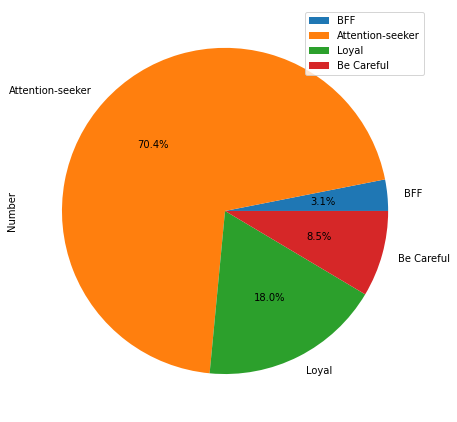

In [30]:
#create pie chart
colors = sns.color_palette('pastel')[0:5]
dfpie.plot.pie(y = 'Number',labels = dfpie['Segment'], autopct="%.1f%%", figsize=(7.5, 7.5));